In [1]:
%cd /users/anglos/Developer/psiphi

/auto/users/anglos/Developer/psiphi


In [2]:
#@title Imports
import jax
import tree

import social_rl

In [3]:
#@title Constants, experiment config.
GOAL_COLOR = 'blue'
NUM_STEPS = 100_000
NUM_ITERATIONS = 1
assert NUM_STEPS % NUM_ITERATIONS == 0
BATCH_SIZE = 128

In [4]:
#@title Initialise environment, agent and replay buffer.
env = social_rl.GridWorld(goal_color=GOAL_COLOR)
agent = social_rl.agents.DQNAgent(env)
buffer = social_rl.replay.ExperienceBuffer(
  batch_size=BATCH_SIZE, capacity=25_000)

  0%|          | 0/100000 [00:00<?, ?it/s]/scratch/anglos/conda_envs/psiphi/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
100%|██████████| 100000/100000 [08:22<00:00, 199.09it/s]


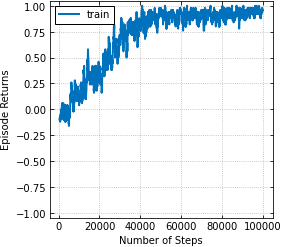

In [5]:
#@title Train agent online.
agent_environment_loop = social_rl.loops.AgentEnvironmentLoop(env, agent, buffer)
params, actor_state, learner_state = None, None, None
rng_key = jax.random.PRNGKey(42)
for iteration in range(NUM_ITERATIONS):
  rng_key, loop_key = jax.random.split(rng_key, num=2)
  params, actor_state, learner_state, agent_stats = agent_environment_loop.run(
    rng_key,
    num_iterations=NUM_STEPS // NUM_ITERATIONS,
    params=params,
    actor_state=actor_state,
    learner_state=learner_state)
  social_rl.plotting.plot_agent_environment_loop_stats(agent_stats)

In [6]:
#@title Evaluate agent online.
def evaluate(env: social_rl.GridWorld) -> float:
  """Return the success rate on `env`."""
  actor_env_loop = social_rl.loops.ActorEnvironmentLoop(env, agent)
  _, actor_stats = actor_env_loop.run(
    jax.random.PRNGKey(42),
    num_iterations=500,
    params=params,
    actor_state=actor_state,
    evaluation=True)
  return actor_stats['returns'].sum() / len(actor_stats['returns'])

environments = {
    goal_color: social_rl.GridWorld(goal_color=goal_color, seed=42)
    for goal_color in ('red', 'green', 'blue')
}
tree.map_structure(evaluate, environments)

100%|██████████| 500/500 [00:00<00:00, 687.22it/s]


{'red': -0.952, 'green': -0.952, 'blue': 0.952}